<a href="https://colab.research.google.com/github/dangmquann/ImageRetrieval/blob/main/ImageRetrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers==4.31.0 -q

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
import cv2

In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/image_retrival_dataset/image_retrieval_dataset.zip

Archive:  /content/drive/MyDrive/Colab_Notebooks/image_retrival_dataset/image_retrieval_dataset.zip
replace images_mr/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
dataset_dir = 'images_mr'
image_filenames = os.listdir(dataset_dir)[:500]
source_imgs = []
for filename in image_filenames :
  file_path = os.path.join(dataset_dir, filename)

  image = cv2.imread(file_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  source_imgs.append(image)


In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224").to(device)

In [27]:

def preprocessing(images):
  inputs = processor(
      images,
      return_tensors='pt'
  ).to(device)

  with torch.no_grad():
    output = model(
        **inputs,
        output_hidden_states=True
    ).hidden_states[-1][:,0,:].detach().cpu().numpy()

  return output


In [23]:
def mean_absolute_error(query_vector,source_vectors):
  abs_diff = np.abs(source_vectors - query_vector)
  mae = np.mean(abs_diff,axis=1)
  return mae

def mean_squared_error(query_vector,source_vectors):
  squared_diff = (source_vectors - query_vector)**2
  mse = np.mean(squared_diff,axis=1)
  return mse

def cosine_similarity(query_vector,source_vectors):
  norm_query = np.linalg.norm(query_vector)
  normalized_query = query_vector / norm_query
  norm_source = np.linalg.norm(source_vectors, axis =1 ) # each row of source vectors
  normalized_source = source_vectors / norm_source[:, np.newaxis]

  cosine = np.dot(
      normalized_source,
      normalized_query )
  return cosine

def corrlation_coefficient(query_vector,source_vectors):
  corr_coef = np.corrcoef(query_vector,source_vectors)[-1:1]
  return corr_coef


In [24]:
def ranking(preprocessed_query_image, preprocessed_source_images, top_k):
  scores = cosine_similarity(
      preprocessed_query_image,
      preprocessed_source_images)
  rank_list = np.argsort(scores)[::-1][:top_k]
  scores = scores[rank_list]
  return rank_list, scores

In [28]:
preprocessed_source_images = preprocessing(source_imgs)

Query Image


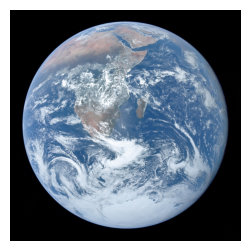

Top 10of results similarity 


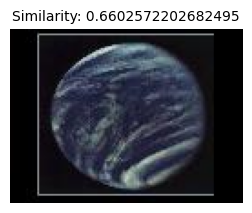

----------------------------------------


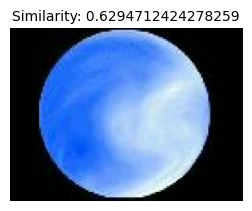

----------------------------------------


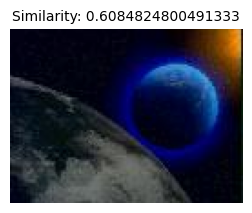

----------------------------------------


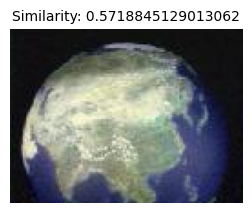

----------------------------------------


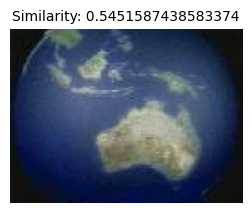

----------------------------------------


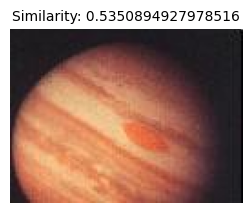

----------------------------------------


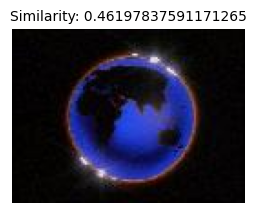

----------------------------------------


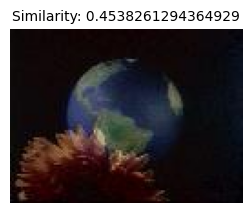

----------------------------------------


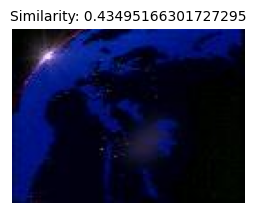

----------------------------------------


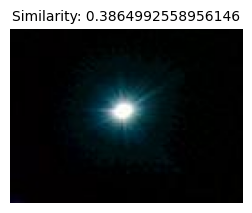

----------------------------------------


In [32]:
query_image_paths = ['/content/earth.jpeg']
top_k = 10
for query_path in query_image_paths:
  image_query = cv2.imread(query_path)
  image_query = cv2.cvtColor(image_query, cv2.COLOR_BGR2RGB)
  preprocessed_query_image = preprocessing(image_query)
  preprocessed_query_image = np.reshape(preprocessed_query_image, (768,))

  rank_list, scores = ranking(preprocessed_query_image, preprocessed_source_images, top_k)

  #Oridinary Image
  print("Query Image")
  plt.figure(figsize=(3,3))
  plt.imshow(image_query)
  plt.axis('off')
  plt.show()

  print(f'Top {top_k}of results similarity ')
  for i in range(len(rank_list)):
    source_idx = rank_list[i]
    similarity_score = scores[i]
    plt.figure(figsize=(3,3))
    plt.imshow(source_imgs[source_idx])
    plt.title(f'Similarity: {similarity_score}', fontsize=10)
    plt.axis('off')
    plt.show()
    print('----------------------------------------')